# Cats vs Dogs

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import glob

In [8]:
# turn off GPU if needed

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [9]:
import tensorflow as tf

from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
print("TensorFlow version:", tf.__version__)
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.12.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preparing filepaths

In [11]:
# set up the folder structure

folder = 'data/dogs-vs-cats/'
train_folder = folder + 'train/'
test_folder = folder + 'test/'

# glob to get the file paths
train_paths = glob.glob(train_folder + '*')
test_paths = glob.glob(test_folder + '*')

In [12]:
# check the file paths

train_paths[0], test_paths[0]

('data/dogs-vs-cats/train/dog.8011.jpg', 'data/dogs-vs-cats/test/9733.jpg')

# Defining variables

In [13]:
BATCH_SIZE = 32
WIDTH = 224
HEIGHT = 224
CHANNELS = 3
INPUT_SHAPE = (HEIGHT, WIDTH, CHANNELS)

# Create test Dataset (no labels)

In [14]:
# load the test dataset, no label extraction needed

def process_test_path(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [224, 224])
  return img

In [15]:
# build the test dataset

test_paths = tf.data.Dataset.list_files(test_paths, shuffle=False)

test_ds = test_paths.map(process_test_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [16]:
# check the test dataset

for images in test_ds.take(1):
  print(images.shape)

(32, 224, 224, 3)


2025-04-19 11:56:20.511009: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Extracting train labels from filepath

In [17]:
# get the class label from the filename

image_name = tf.strings.split(train_paths[0], sep='/')
label_tf = tf.strings.split(image_name[-1], sep='.')[0]
label_decoded = label_tf.numpy().decode()
label_decoded


'dog'

In [18]:
# create a dictionary to track the class names

class_names = {0: 'cat', 1: 'dog'}
class_names

{0: 'cat', 1: 'dog'}

In [19]:
# create the a tf function to get the class label from the filename

def get_label(file_path):
  filename = tf.strings.split(file_path, '/')[-1]
  label_str = tf.strings.split(filename, sep='.')[0]

  # map label to integer
  label = tf.where(tf.equal(label_str, 'dog'), 1, 0)
  return label


In [20]:
# create a function to decode the actual images into tensors

def decode_img(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [224, 224])
  return img

In [21]:
# create function to use the above 2 functions to return image and label pairs

def process_path(file_path):
  label = get_label(file_path)
  image = decode_img(file_path)
  return image, label

# Train/Val Split

In [22]:
# split train and val manually

# shuffle the list
train_paths = tf.random.shuffle(train_paths)

# split 80% train / 20% val
split_idx = int(0.8 * len(train_paths))

train_paths_split = train_paths[:split_idx]
val_paths_split = train_paths[split_idx:]

In [23]:
# create tensorflow datasets

train_ds = tf.data.Dataset.from_tensor_slices(train_paths_split)
val_ds = tf.data.Dataset.from_tensor_slices(val_paths_split)

In [24]:
# for each file path, load and process the image and label
# automatically optimize how many processes it uses to load and process files in parallel

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
# check the train dataset

for images, labels in train_ds.take(1):
  print(images.shape)
  print(labels.numpy())

(224, 224, 3)
1


In [26]:
# check the val dataset

for images, labels in val_ds.take(1):
  print(images.shape)
  print(labels.numpy())

(224, 224, 3)
1


# Optimizing the Dataset

In [27]:
# optimize the datasets

train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# check train & val

train_ds, val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Modeling

In [28]:
# define the CNN model

def build_cnn():
  model = Sequential()
  model.add(Rescaling(1./255, input_shape=INPUT_SHAPE))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [29]:
# create the model

default_model = build_cnn()
default_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 flatten (Flatten)           (None, 1605632)           0         
                                                                 
 dense (Dense)               (None, 2)                 3211266   
                                                                 
Total params: 3,212,162
Trainable params: 3,212,162
Non-trainable params: 0
_________________________________________________________________


In [30]:
# fit the model

history = default_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=25,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
625/625 [==============================] - 38s 60ms/step - loss: 1.2110 - accuracy: 0.6281 - val_loss: 0.6050 - val_accuracy: 0.6912
Epoch 2/25
625/625 [==============================] - 60s 96ms/step - loss: 0.5055 - accuracy: 0.7545 - val_loss: 0.6066 - val_accuracy: 0.6974
Epoch 3/25
625/625 [==============================] - 58s 92ms/step - loss: 0.3267 - accuracy: 0.8627 - val_loss: 0.7185 - val_accuracy: 0.6848
Epoch 4/25
625/625 [==============================] - 48s 77ms/step - loss: 0.1863 - accuracy: 0.9301 - val_loss: 0.9058 - val_accuracy: 0.6864


# Evaluate the Model

In [31]:
# define a function to plot history

def plot_history(history):
  for metric in history.history.keys():
    if not metric.startswith('val'):        # if it doesn't start with val
      plt.plot(history.history[metric], label=metric)
      if f'val_{metric}' in history.history.keys():     # if val is in the keys, then plot that as well
        plt.plot(history.history[f'val_{metric}'], label=f'val+{metric}')
      plt.title(metric)
      plt.legend()
      plt.show()

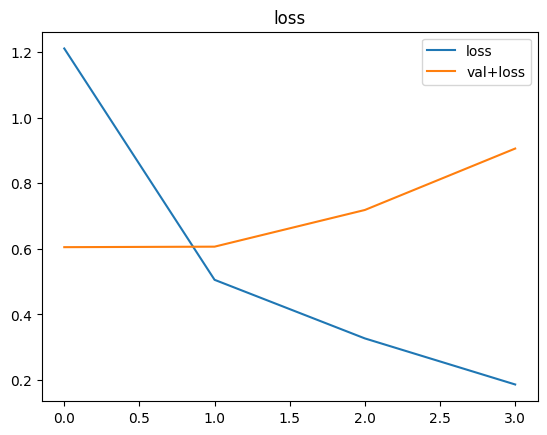

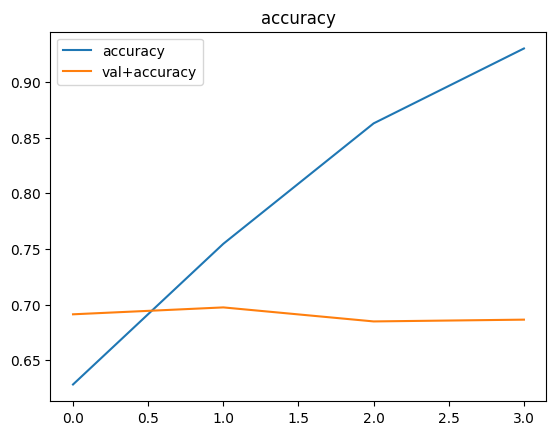

In [32]:
# plot the metrics

plot_history(history)

- while train continues to improve, val is not improving at all, rather, becomes gradually worse

# Improve the model

### Model #2

In [33]:
# define the CNN model

def build_cnn():
  model = Sequential()
  model.add(Rescaling(1./255, input_shape=INPUT_SHAPE))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [34]:
# create the model

default_model = build_cnn()
default_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 flatten_1 (Flatten)         (None, 1605632)           0         
                                                                 
 dense_1 (Dense)             (None, 2)                 3211266   
                                                                 
Total params: 3,221,410
Trainable params: 3,221,410
Non-trainable params: 0
_________________________________________________________________


In [35]:
# fit the model

history = default_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=25,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
625/625 [==============================] - 93s 146ms/step - loss: 0.9736 - accuracy: 0.5884 - val_loss: 0.6737 - val_accuracy: 0.5506
Epoch 2/25
625/625 [==============================] - 101s 161ms/step - loss: 0.5706 - accuracy: 0.7006 - val_loss: 0.6248 - val_accuracy: 0.6442
Epoch 3/25
625/625 [==============================] - 94s 151ms/step - loss: 0.3830 - accuracy: 0.8241 - val_loss: 0.6544 - val_accuracy: 0.6836
Epoch 4/25
625/625 [==============================] - 97s 156ms/step - loss: 0.2063 - accuracy: 0.9208 - val_loss: 0.9125 - val_accuracy: 0.6716
Epoch 5/25
625/625 [==============================] - 96s 153ms/step - loss: 0.1214 - accuracy: 0.9609 - val_loss: 1.3923 - val_accuracy: 0.6606


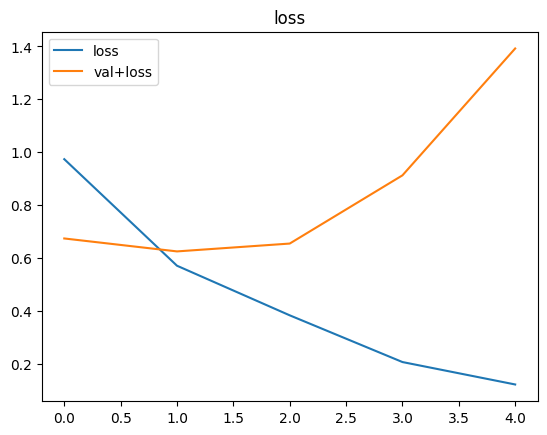

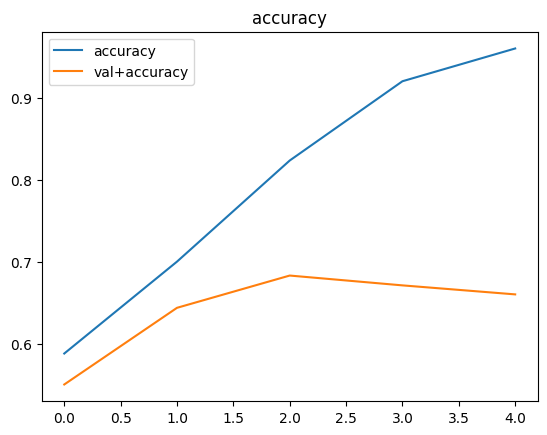

In [36]:
# plot the metrics

plot_history(history)

- the loss for val is worse with 2 layers than 1
- the accuracy for val is slightly better with 2 layers than 1

### Model #3

In [37]:
# define the CNN model

def build_cnn():
  model = Sequential()
  model.add(Rescaling(1./255, input_shape=INPUT_SHAPE))
  model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [38]:
# create the model

default_model = build_cnn()
default_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 flatten_2 (Flatten)         (None, 802816)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1605634   
                                                                 
Total params: 1,608,402
Trainable params: 1,608,402
Non-trainable params: 0
_________________________________________________________________


In [39]:
# fit the model

history = default_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=25,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
625/625 [==============================] - 44s 68ms/step - loss: 0.8902 - accuracy: 0.6046 - val_loss: 0.6338 - val_accuracy: 0.6626
Epoch 2/25
625/625 [==============================] - 45s 71ms/step - loss: 0.5149 - accuracy: 0.7436 - val_loss: 0.6159 - val_accuracy: 0.6912
Epoch 3/25
625/625 [==============================] - 45s 72ms/step - loss: 0.3023 - accuracy: 0.8739 - val_loss: 0.7695 - val_accuracy: 0.6486
Epoch 4/25
625/625 [==============================] - 49s 78ms/step - loss: 0.1595 - accuracy: 0.9430 - val_loss: 1.1383 - val_accuracy: 0.6336
Epoch 5/25
625/625 [==============================] - 44s 71ms/step - loss: 0.1011 - accuracy: 0.9677 - val_loss: 1.6252 - val_accuracy: 0.6406


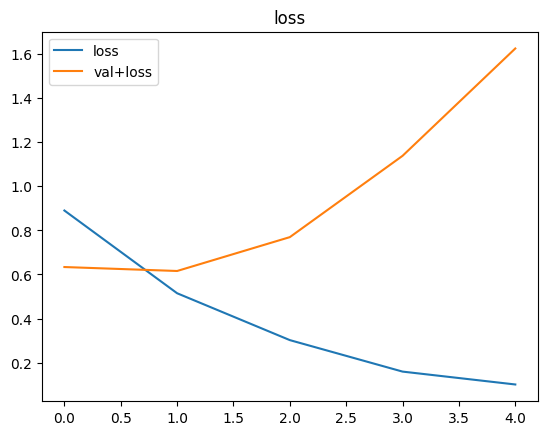

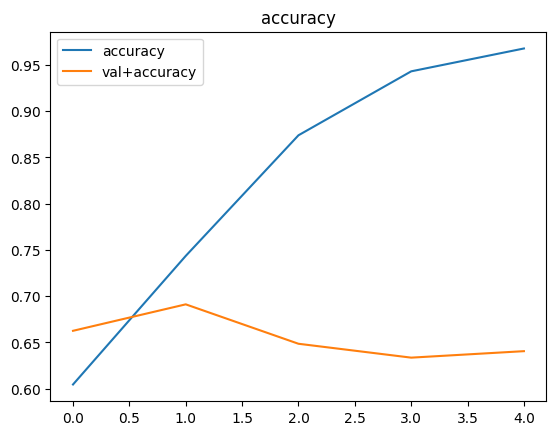

In [40]:
# plot the metrics

plot_history(history)

- Accuracy for val decreased

### Model 4

In [41]:
# define the CNN model

def build_cnn():
  model = Sequential()
  model.add(Rescaling(1./255, input_shape=INPUT_SHAPE))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [42]:
# create the model

default_model = build_cnn()
default_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 224, 224, 64)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 dropout_1 (Dropout)         (None, 224, 224, 64)      0         
                                                                 
 flatten_3 (Flatten)         (None, 3211264)           0         
                                                                 
 dense_3 (Dense)             (None, 2)                

In [43]:
# fit the model

history = default_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=25,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
625/625 [==============================] - 295s 470ms/step - loss: 0.9457 - accuracy: 0.5087 - val_loss: 0.6933 - val_accuracy: 0.4984
Epoch 2/25
625/625 [==============================] - 291s 465ms/step - loss: 0.6940 - accuracy: 0.5155 - val_loss: 0.6942 - val_accuracy: 0.4992
Epoch 3/25
625/625 [==============================] - 290s 464ms/step - loss: 0.6698 - accuracy: 0.5668 - val_loss: 0.7011 - val_accuracy: 0.5036
Epoch 4/25
625/625 [==============================] - 298s 476ms/step - loss: 0.5717 - accuracy: 0.6701 - val_loss: 0.7932 - val_accuracy: 0.5200


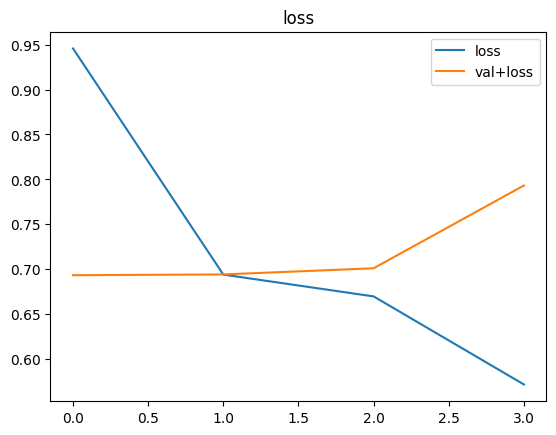

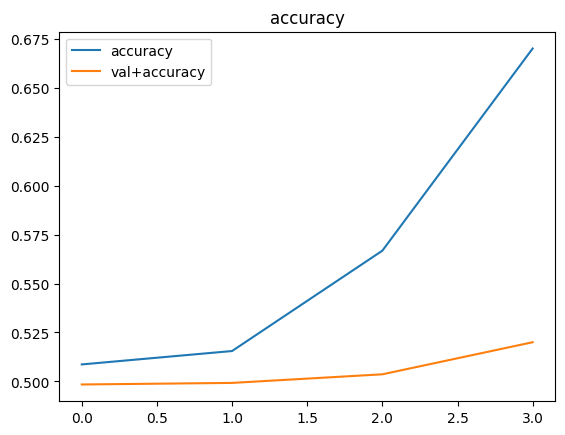

In [44]:
# plot the metrics

plot_history(history)

### Model #5

In [45]:
# define the CNN model

def build_cnn():
  model = Sequential()
  model.add(Rescaling(1./255, input_shape=INPUT_SHAPE))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [46]:
# create the model

default_model = build_cnn()
default_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 dropout_2 (Dropout)         (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 74, 74, 64)        36928     
                                                                 
 dropout_3 (Dropout)         (None, 74, 74, 64)        0         
                                                      

In [47]:
# fit the model

history = default_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=25,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
625/625 [==============================] - 125s 198ms/step - loss: 0.6503 - accuracy: 0.6259 - val_loss: 0.5774 - val_accuracy: 0.7184
Epoch 2/25
625/625 [==============================] - 122s 195ms/step - loss: 0.5276 - accuracy: 0.7381 - val_loss: 0.5402 - val_accuracy: 0.7406
Epoch 3/25
625/625 [==============================] - 128s 204ms/step - loss: 0.4622 - accuracy: 0.7812 - val_loss: 0.4982 - val_accuracy: 0.7668
Epoch 4/25
625/625 [==============================] - 126s 202ms/step - loss: 0.4123 - accuracy: 0.8085 - val_loss: 0.5024 - val_accuracy: 0.7644
Epoch 5/25
625/625 [==============================] - 124s 199ms/step - loss: 0.3662 - accuracy: 0.8354 - val_loss: 0.5171 - val_accuracy: 0.7596
Epoch 6/25
625/625 [==============================] - 113s 180ms/step - loss: 0.3220 - accuracy: 0.8579 - val_loss: 0.5106 - val_accuracy: 0.7618


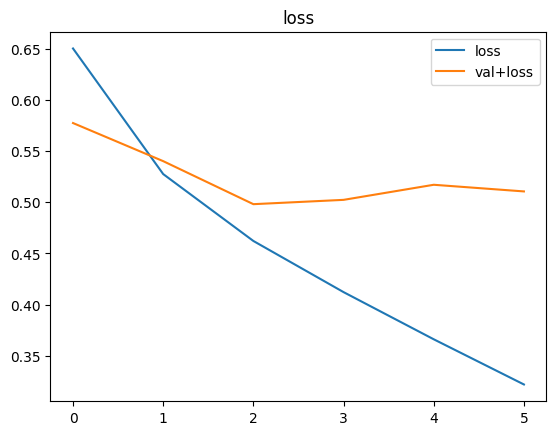

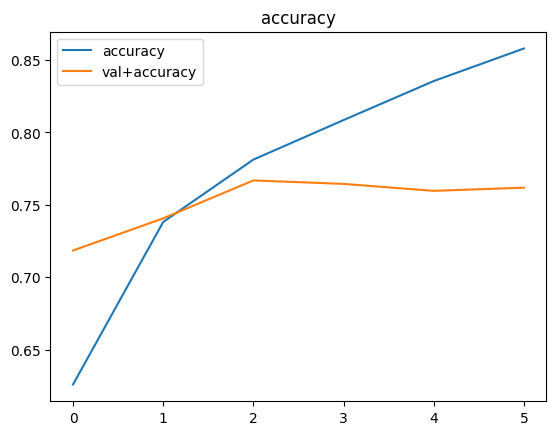

In [48]:
# plot the metrics

plot_history(history)

- the loss, accuracy and overfitting have all improved

### Model #6

In [49]:
# define the CNN model

def build_cnn():
  model = Sequential()
  model.add(Rescaling(1./255, input_shape=INPUT_SHAPE))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(MaxPooling2D(pool_size=3, padding='valid'))
  model.add(Flatten())
  model.add(Dense(units=len(class_names), activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [50]:
# create the model

default_model = build_cnn()
default_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 dropout_4 (Dropout)         (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 74, 74, 64)        36928     
                                                                 
 dropout_5 (Dropout)         (None, 74, 74, 64)        0         
                                                      

In [51]:
# fit the model

history = default_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=25,
                            callbacks=[EarlyStopping(patience=3, restore_best_weights=True)])

Epoch 1/25
625/625 [==============================] - 127s 201ms/step - loss: 0.5957 - accuracy: 0.6685 - val_loss: 0.5613 - val_accuracy: 0.7266
Epoch 2/25
625/625 [==============================] - 130s 208ms/step - loss: 0.4625 - accuracy: 0.7819 - val_loss: 0.4722 - val_accuracy: 0.7812
Epoch 3/25
625/625 [==============================] - 130s 207ms/step - loss: 0.3920 - accuracy: 0.8257 - val_loss: 0.4400 - val_accuracy: 0.7978
Epoch 4/25
625/625 [==============================] - 130s 207ms/step - loss: 0.3359 - accuracy: 0.8555 - val_loss: 0.4296 - val_accuracy: 0.8012
Epoch 5/25
625/625 [==============================] - 135s 215ms/step - loss: 0.2945 - accuracy: 0.8758 - val_loss: 0.4524 - val_accuracy: 0.7818
Epoch 6/25
625/625 [==============================] - 206s 329ms/step - loss: 0.2586 - accuracy: 0.8928 - val_loss: 0.4565 - val_accuracy: 0.7836
Epoch 7/25
625/625 [==============================] - 170s 272ms/step - loss: 0.2283 - accuracy: 0.9050 - val_loss: 0.3976 -

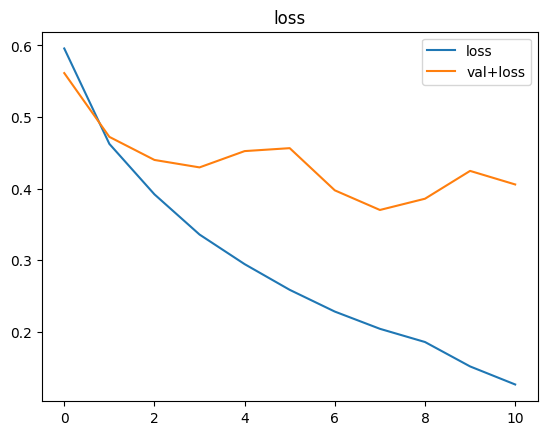

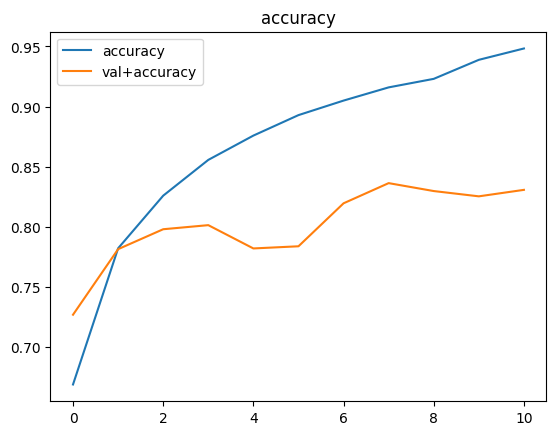

In [52]:
# plot the metrics

plot_history(history)

- the val is more unstable, likely due to the dropout layers
- no significant improvement to val results